In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization  
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.39 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

#Tiền xử lý dữ liệu

In [7]:
def get_lines(filename):
  with open(filename) as f:
    return f.readlines()

In [8]:
train_lines = get_lines(filenames[0])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
stemmer = PorterStemmer()

def preprocess(text, stopwords=STOPWORDS):
  text = text.lower()

  pattern = re.compile(r"\b(" + r"|".join(stopwords) +r")\b\s*")
  text = pattern.sub("", text)

  text = re.sub(r"\([^)]*\)", "", text)

  # Spacing and filters
  text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
  text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
  text = re.sub(" +", " ", text)  # remove multiple spaces
  text = text.strip()

  # words = word_tokenize(text)
  # stemmed_words = [stemmer.stem(word) for word in words]

  # text = " ".join(stemmed_words)
  return text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  for line in input_lines:
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = "" 
    elif line.isspace(): 
      abstract_line_split = abstract_lines.splitlines() 

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} 
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = preprocess(target_text_split[1]) 
        line_data["line_number"] = abstract_line_number  
        line_data["total_lines"] = len(abstract_line_split) - 1 
        abstract_samples.append(line_data) 
    else: 
      abstract_lines += line
  
  return abstract_samples

In [11]:
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
val_samples = preprocess_text_with_line_numbers(filenames[1]) 
test_samples = preprocess_text_with_line_numbers(filenames[2])
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 12.4 s, sys: 112 ms, total: 12.5 s
Wall time: 23 s


(180040, 30212, 30135)

In [12]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'investigate efficacy weeks daily low dose oral prednisolone improving pain mobility systemic low grade inflammation short term whether effect would sustained weeks older adults moderate severe knee osteoarthritis',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'total patients primary knee oa randomized received mg day prednisolone received placebo weeks',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction improvement function scores systemic inflammation markers',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain assessed using visual analog pain scale',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included western ontario mcmaster universities osteoarthritis index scores patient global assessment severity knee oa min walk distance',
  'line_number': 4,
  'total_lines':

In [13]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,investigate efficacy weeks daily low dose oral...,0,11
1,METHODS,total patients primary knee oa randomized rece...,1,11
2,METHODS,outcome measures included pain reduction impro...,2,11
3,METHODS,pain assessed using visual analog pain scale,3,11
4,METHODS,secondary outcome measures included western on...,4,11
5,METHODS,serum levels interleukin il tumor necrosis fac...,5,11
6,RESULTS,clinically relevant reduction intervention gro...,6,11
7,RESULTS,mean difference treatment arms p p p p respect...,7,11
8,RESULTS,clinically relevant reduction serum levels il ...,8,11
9,RESULTS,differences remained significant weeks,9,11


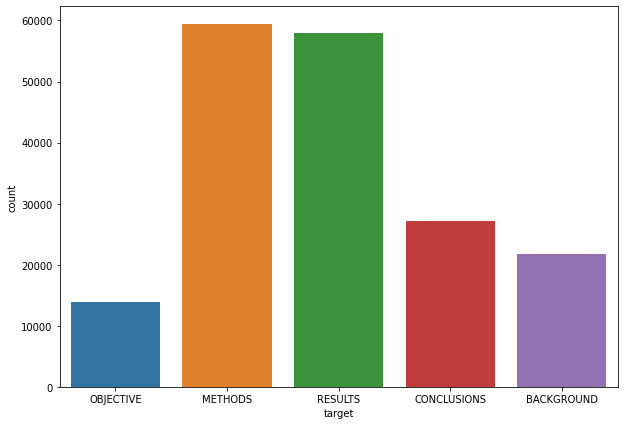

In [14]:
plt.figure(figsize=(10,7))
sns.countplot(x=train_df['target']);

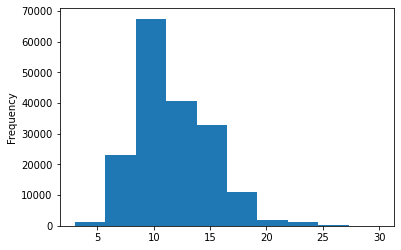

In [15]:
train_df.total_lines.plot.hist();

# List of sentences

In [16]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

#Making Numeric labels

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
class_names = label_encoder.classes_
num_classes = len(class_names)
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accurecy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

#Model 0: Tạo mô hình cơ sở

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 0, 3, ..., 4, 4, 2])

In [23]:
calculate_result(y_true=val_labels_encoded,
                 y_pred=baseline_preds)

{'accurecy': 0.6965444194359857,
 'precision': 0.6938647363184476,
 'recall': 0.6965444194359857,
 'f1-score': 0.6726859104649595}

#Model_1: BERT_Model

## Character level Tokeninzer

In [24]:
def split_character(text):
  return ' '.join(list(text))

In [25]:
train_chars = [split_character(sentence) for sentence in train_sentences]
val_chars = [split_character(sentence) for sentence in val_sentences]
test_chars = [split_character(sentence) for sentence in test_sentences]
print(train_chars[0])

i n v e s t i g a t e   e f f i c a c y   w e e k s   d a i l y   l o w   d o s e   o r a l   p r e d n i s o l o n e   i m p r o v i n g   p a i n   m o b i l i t y   s y s t e m i c   l o w   g r a d e   i n f l a m m a t i o n   s h o r t   t e r m   w h e t h e r   e f f e c t   w o u l d   s u s t a i n e d   w e e k s   o l d e r   a d u l t s   m o d e r a t e   s e v e r e   k n e e   o s t e o a r t h r i t i s


In [26]:
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

198

In [27]:
# Lấy tất cả các ký tự từ bàn phím cho char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
from tensorflow.keras.layers import TextVectorization, Embedding

NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [29]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 'i', 't']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


## Tạo embedding ở cấp độ ký tự

In [30]:
char_embed = Embedding(input_dim=NUM_CHAR_TOKENS,
                       output_dim=25,
                       mask_zero=False,
                       name='char_embed')

#Positional Embedding Layer

In [31]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

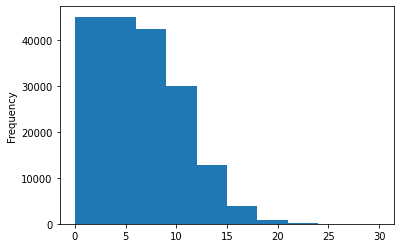

In [32]:
train_df['line_number'].plot.hist()

Phần lớn số dòng đều nằm ở dòng 15 trở xuống

In [33]:
np.percentile(train_df.line_number, 98)

15.0

In [34]:
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [35]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:5]

(TensorShape([180040, 15]), <tf.Tensor: shape=(5, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>)

In [36]:
# Có bao nhiêu dòng khác nhau ở đây?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

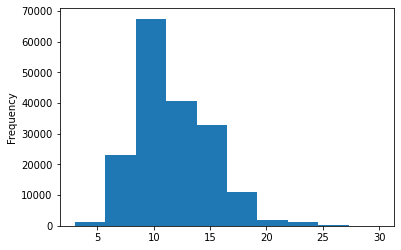

In [37]:
train_df["total_lines"].plot.hist()

In [38]:
np.percentile(train_df.total_lines, 98)

20.0

In [39]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:5]

(TensorShape([180040, 20]), <tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>)

#Creating datasets

In [40]:
train_inputs = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_ds = tf.data.Dataset.zip((train_inputs, train_labels))
train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

val_inputs = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_ds = tf.data.Dataset.zip((val_inputs, val_labels))
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

test_inputs = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_ds = tf.data.Dataset.zip((test_inputs, test_labels))
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [41]:
train_ds

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Using BERT

In [42]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [43]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_preprocessing')
bert_model = hub.KerasLayer(tfhub_handle_encoder, name='BERT_encoder', trainable=False)

In [44]:
# 1. Token inputs
token_inputs = layers.Input(shape=(), dtype=tf.string, name='token_inputs')
bert_input = preprocess_layer(token_inputs)
bert_output = bert_model(bert_input)
sequence_output = bert_output['pooled_output']
token_outputs = layers.Dense(128, activation='relu')(sequence_output)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_numbers_input')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. total line model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

# Nối token và char
token_char_concat = layers.Concatenate(name='concat_layer')([token_model.output,
                                                            char_model.output])
# Add dropout
x = layers.Dense(256, activation='relu')(token_char_concat)
x = layers.Dropout(0.5)(x)

# Nối total_line, line_number và token_char_concat
final_concat = layers.Concatenate(name='final_concat')([line_number_model.output,
                                                        total_lines_model.output,
                                                        x])
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_concat)

model = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_lines_model.input,
        token_model.input,
        char_model.input
    ],
    outputs=outputs
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [45]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 BERT_preprocessing (KerasLayer  {'input_word_ids':   0          ['token_inputs[0][0]']           
 )                              (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                

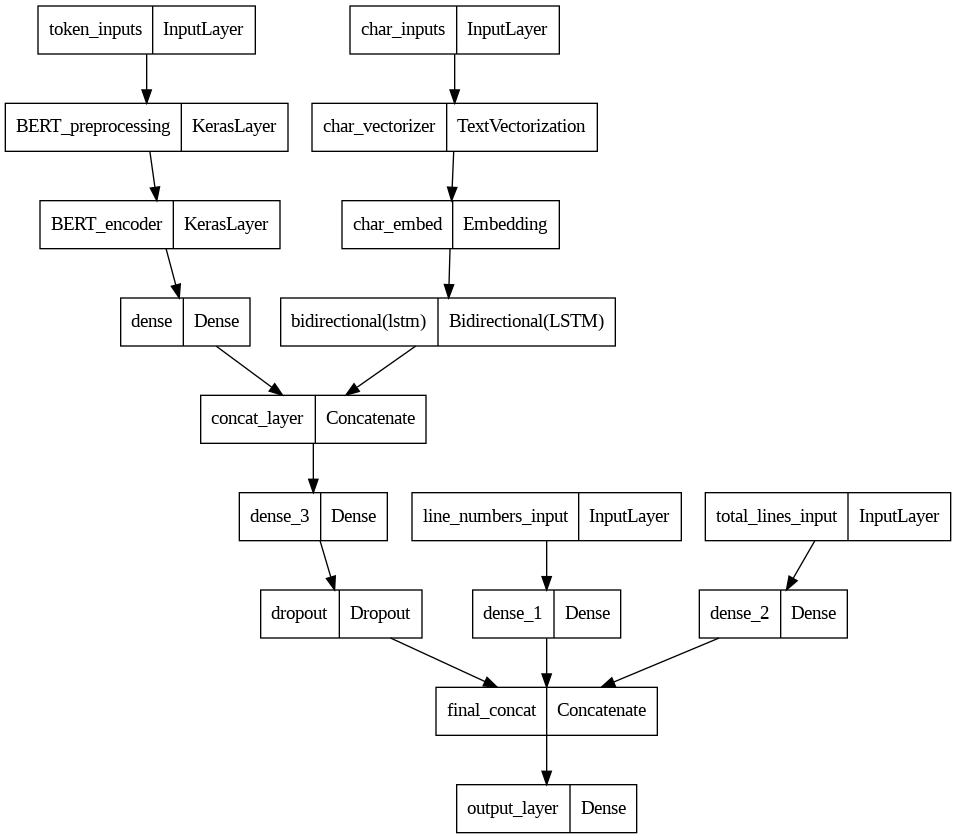

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [51]:
epochs = 10
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=loss,
              metrics=['accuracy'])

In [53]:
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/PROJECT/NLP/skimlit_BERT', save_best_only=True),] 
                    )

Epoch 1/10
5626/5627 [============================>.] - ETA: 0s - loss: 1.0615 - accuracy: 0.7476

5627/5627 [==============================] - 922s 163ms/step - loss: 1.0615 - accuracy: 0.7476 - val_loss: 1.0015 - val_accuracy: 0.7854
Epoch 2/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9998 - accuracy: 0.7890

5627/5627 [==============================] - 934s 166ms/step - loss: 0.9998 - accuracy: 0.7890 - val_loss: 0.9791 - val_accuracy: 0.8011
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9816 - accuracy: 0.8020

5627/5627 [==============================] - 891s 158ms/step - loss: 0.9816 - accuracy: 0.8020 - val_loss: 0.9663 - val_accuracy: 0.8112
Epoch 4/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.8122

5627/5627 [==============================] - 892s 159ms/step - loss: 0.9703 - accuracy: 0.8122 - val_loss: 0.9585 - val_accuracy: 0.8161
Epoch 5/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9625 - accuracy: 0.8175

5627/5627 [==============================] - 931s 166ms/step - loss: 0.9625 - accuracy: 0.8175 - val_loss: 0.9538 - val_accuracy: 0.8201
Epoch 6/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9567 - accuracy: 0.8216

5627/5627 [==============================] - 892s 159ms/step - loss: 0.9567 - accuracy: 0.8216 - val_loss: 0.9491 - val_accuracy: 0.8233
Epoch 7/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9517 - accuracy: 0.8256

5627/5627 [==============================] - 894s 159ms/step - loss: 0.9517 - accuracy: 0.8256 - val_loss: 0.9460 - val_accuracy: 0.8261
Epoch 8/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.8282

5627/5627 [==============================] - 896s 159ms/step - loss: 0.9473 - accuracy: 0.8282 - val_loss: 0.9446 - val_accuracy: 0.8262
Epoch 9/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9440 - accuracy: 0.8313

5627/5627 [==============================] - 927s 165ms/step - loss: 0.9440 - accuracy: 0.8313 - val_loss: 0.9416 - val_accuracy: 0.8289
Epoch 10/10
5626/5627 [============================>.] - ETA: 0s - loss: 0.9407 - accuracy: 0.8333

5627/5627 [==============================] - 927s 165ms/step - loss: 0.9407 - accuracy: 0.8333 - val_loss: 0.9393 - val_accuracy: 0.8299


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


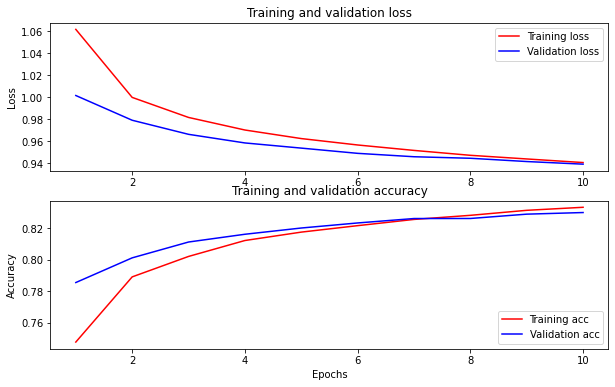

In [54]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [55]:
model.save("/content/drive/MyDrive/PROJECT/NLP/saved_model/skimlit_model")

In [56]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/PROJECT/NLP/saved_model/skimlit_model")

In [57]:
loaded_pred_probs = loaded_model.predict(val_ds, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 116s 121ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [58]:
loaded_model_results = calculate_result(val_labels_encoded,
                                        loaded_preds)
loaded_model_results

{'accurecy': 0.829935125115848,
 'precision': 0.8314369136480153,
 'recall': 0.829935125115848,
 'f1-score': 0.8259691800456316}